In [1]:
import cv2 as cv
import numpy as np
from os import walk
import matplotlib.pyplot as plt

%matplotlib inline
figsize = (15,22)

def _plot(img):
    plt.figure(figsize=figsize)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

## Global Constants

In [2]:
path = './data/image_database/'
queries = [4, 40, 60, 588, 1562]

## Data Loading

In [3]:
def load_data(path):
    frame_coll = []
    for (dirpath, dirnames, filenames) in walk(path):
        for f in filenames:
            file_path = dirpath + f
            img = cv.imread(file_path, cv.IMREAD_COLOR)
            frame_coll.append(img)
            
    return np.array(frame_coll)

In [4]:
%%time
frame_coll = load_data(path)

Wall time: 13.2 s


## Extract Color Histograms (with optional task of color histograms)

The idea here is simple since we can't compare images for equality in pixel by pixel manner for obvious reasons(lightning, rotation, etc.) we could create a histogram of an image and compare them instead. In that case, we will avoid any problem concerning the moderate geometric transformation of an image. We can also solve the problems with different lightning via a different kind of histogram standardization for the entire range.

**NOTE:** to achieve better accuracy we will create histograms with all color channels, instead of simply converting it to greyscale image and losing a lot of information. To make it easier to implement, instead of operating 3-dimensional histograms, we will introduce an artificial histogram, where we simply concatenate histograms of each color channel to the end of each other. So below we will create those for every image in database based on BGR color base

In [5]:
def get_hist(img, channel=0):
    '''Returns a histogram of @img based on specified @channel '''
    return np.array(cv.calcHist([img], [channel], mask=None, histSize=[255], ranges=[0,255]), dtype=np.int)

def get_hist_img(img, toHSV):
    '''
    Returns artificial @img histogram, which is built by concatenating histograms along each channel.
    If @toHSV is True, then histogram is calculated in HSV base
    '''
    if toHSV: img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
        
    hist = np.empty(0, dtype=np.int)
    for c in range(3):
        hist = np.append(hist, get_hist(img, channel=c))

    return hist

def get_hist_coll(frame_coll, hist_func):
    '''
    Returns a collection of color histograms for each image in @frame_coll.
    Histogram is calculated with specified @hist_func
    '''
    hist_coll = []
    for i in range(len(frame_coll)):
        hist = hist_func(frame_coll[i])
        hist_coll.append(hist)
        
    return hist_coll

In [6]:
%%time
hist_coll_rgb = get_hist_coll(frame_coll, lambda img: get_hist_img(img, toHSV=False))

Wall time: 1.21 s


## Find Best Matches For Queries

Once we have histogram for every image, searching N most similar images is pretty straightforward. We will:
* calculate histogram of a queried image
* calculate the euclidian distance between histograms of queried image and every image in the dataset
* return N dataset images with smallest distances to queried image

For implementation purposes, here we also return a cached collection of those euclidian distances of every queried image to every image in dataset, which is also normalized and mirrored. We will need it later for plotting Precision-Recall curve.

In [7]:
def get_matches(queries, hist_coll, N=10):
    '''
    For each query index in @queries, calculates Euclidian distance to all image color histograms in @hist_coll.
    Then closest @N image indices are identified. Returns array of tuples with @N closesest indices and
    cached collection of distances for each image in dataset. 
    '''
    match_coll = []
    dist_coll = []
    for q in queries:
        query_hist = hist_coll[q]
        dist = np.linalg.norm(query_hist-hist_coll, axis=1)
        
        match_idx = np.argsort(dist)[:N]
        match_coll.append(match_idx)
        
        
        dist = 1 - (dist - np.min(dist)) / (np.max(dist) - np.min(dist))
        dist_coll.append(dist)
    
    match_coll = np.array(match_coll)
    dist_coll = np.array(dist_coll)
    return match_coll, dist_coll

In [8]:
%%time
match_coll, dist_coll = get_matches(queries, hist_coll_rgb)

Wall time: 140 ms


## Results Investigation

In [9]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def plot_matches(query, matches):
    '''
    Plots @query as main and biggest image, while
    its @matches are located below in a form of thumbnails
    '''
    fig = plt.figure(constrained_layout=True, figsize=(12,14))
    gs = GridSpec(6, 5, figure=fig)
    ax1 = fig.add_subplot(gs[0:4, :])
    for i in range(4, 6):
        for j in range(5):
            fig.add_subplot(gs[i, j])  

    axes_list = [ax for i, ax in enumerate(fig.axes)] 
    
    ax = axes_list.pop(0)
    query = cv.cvtColor(query, cv.COLOR_BGR2RGB)
    ax.imshow(query)

    for img in matches:
        ax = axes_list.pop(0)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        ax.imshow(img)


In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from inspect import signature

def pr_curve(query_idx, y_score):
    '''
    Plots Precision-Recall curve for the query. Where @query_idx is the index of queried image,
    @y_score results of comparing it to all images in datasets
    '''
    y_test = np.array([False] * len(y_score))
    
    true_label = query_idx - (query_idx % 4)
    shift = np.array([0,1,2,3], dtype=np.int)
    y_test[shift + true_label] = True
    
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

So, below in each cell we are going to output each queried image *(the big one)* and top 10 the most similar images from dataset *(thumbnails below the queried image)*. Please not that in dataset we have exactly for images for each object(with some modification of rotation, brightening), so we would expect to see those 4 images as the most similar one

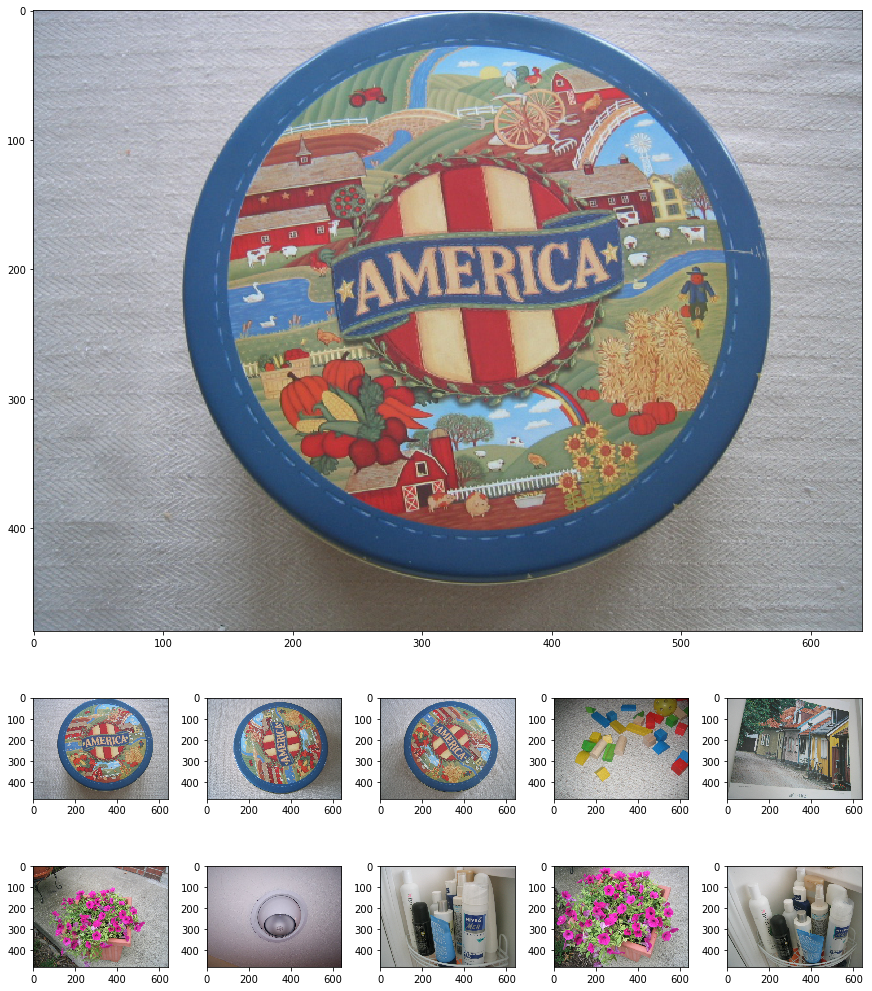

In [11]:
i = 0
query = frame_coll[queries[i]]
matches = np.take(frame_coll, match_coll[i], axis=0)
plot_matches(query, matches)

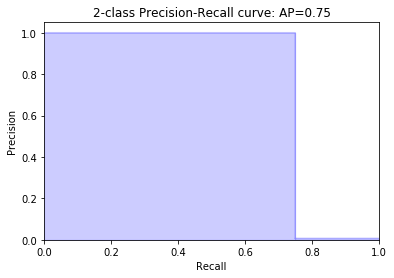

In [12]:
pr_curve(queries[i], dist_coll[i])

As we can see, from there is only 3 out of 4 target images founded by our algorithm. That is also shown on Precision-Recall curve, for which the best threshold will cover 3/4 of target images. Let's examine target images and their histograms and try to find out where is the problem

In [13]:
def plot_patch(query_idx, data, hist=False):
    start = query_idx - (query_idx % 4)
    fig = plt.figure(constrained_layout=True, figsize=(12,14))
    gs = GridSpec(2, 2, figure=fig)
    for i in range(2):
        for j in range(2):
            fig.add_subplot(gs[i, j])  

    axes_list = [ax for i, ax in enumerate(fig.axes)] 
    
    for i in range(start, start + 4):
        ax = axes_list.pop(0)
        if hist:
            x = list(range(len(data[i])))
            ax.bar(x, data[i])
        else:
            ax.imshow(cv.cvtColor(data[i], cv.COLOR_BGR2RGB))

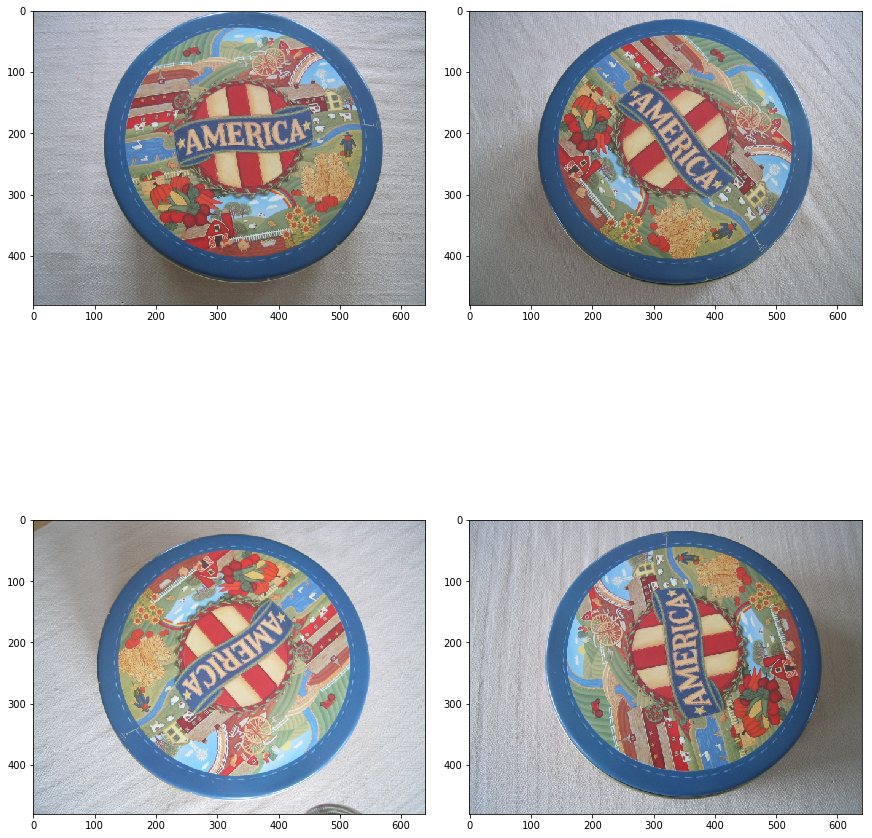

In [14]:
plot_patch(queries[i], frame_coll, hist=False)

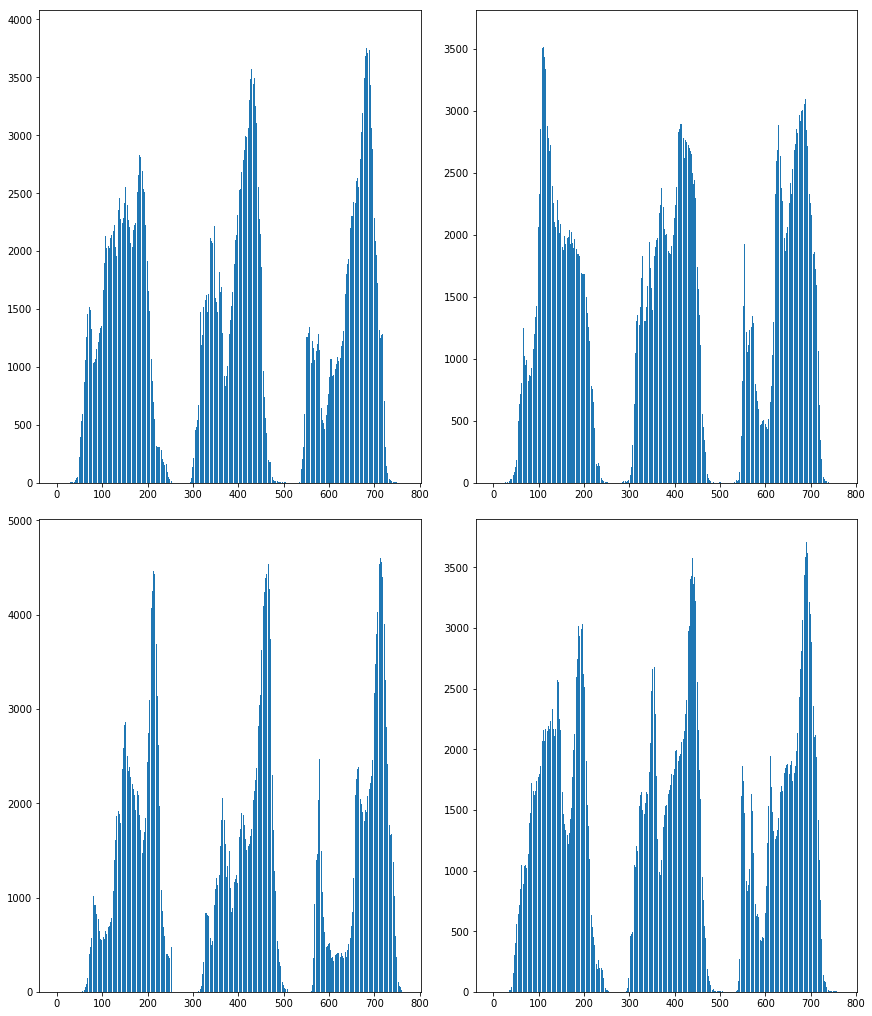

In [15]:
plot_patch(queries[i], hist_coll_rgb, hist=True)

As we can see here, for the top-right image a histogram for Blue channel *(the first one)* is completely different, with a peak in opposite direction, which should give a huge L2 error and thus we can't find it with our algorithm. We don't have a strong argument what could be the case; probably it might be a brightening.

But let's recalculate our histograms in HSV space since it better reflects how humans perceive color changes than RGB. Maybe, that will help us to improve performance

## Transition to HSV color base

In [16]:
%%time
hist_coll_hsv = get_hist_coll(frame_coll, lambda img: get_hist_img(img, toHSV=True))
match_coll, dist_coll = get_matches(queries, hist_coll_hsv)

Wall time: 3.6 s


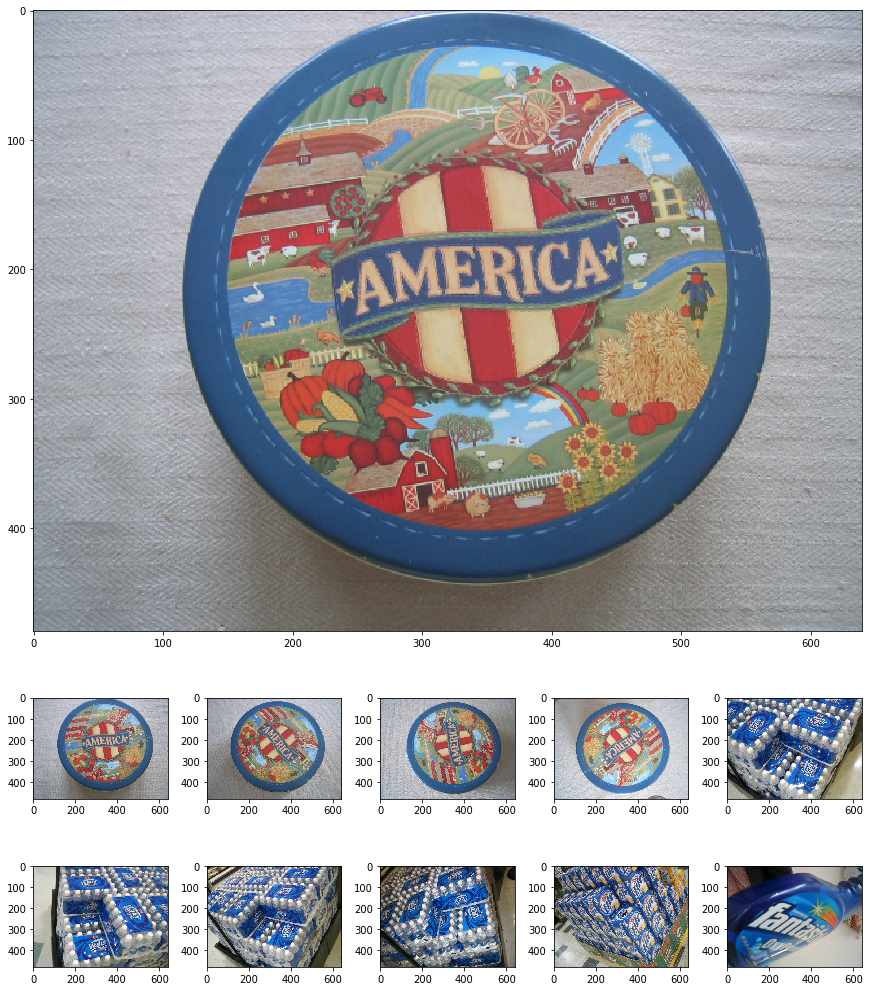

In [17]:
i = 0
query = frame_coll[queries[i]]
matches = np.take(frame_coll, match_coll[i], axis=0)
plot_matches(query, matches)

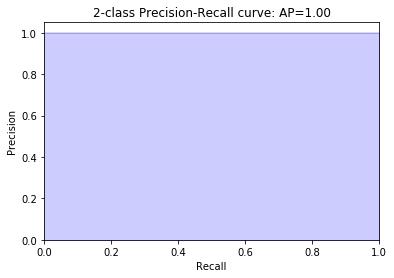

In [18]:
pr_curve(queries[i], dist_coll[i])

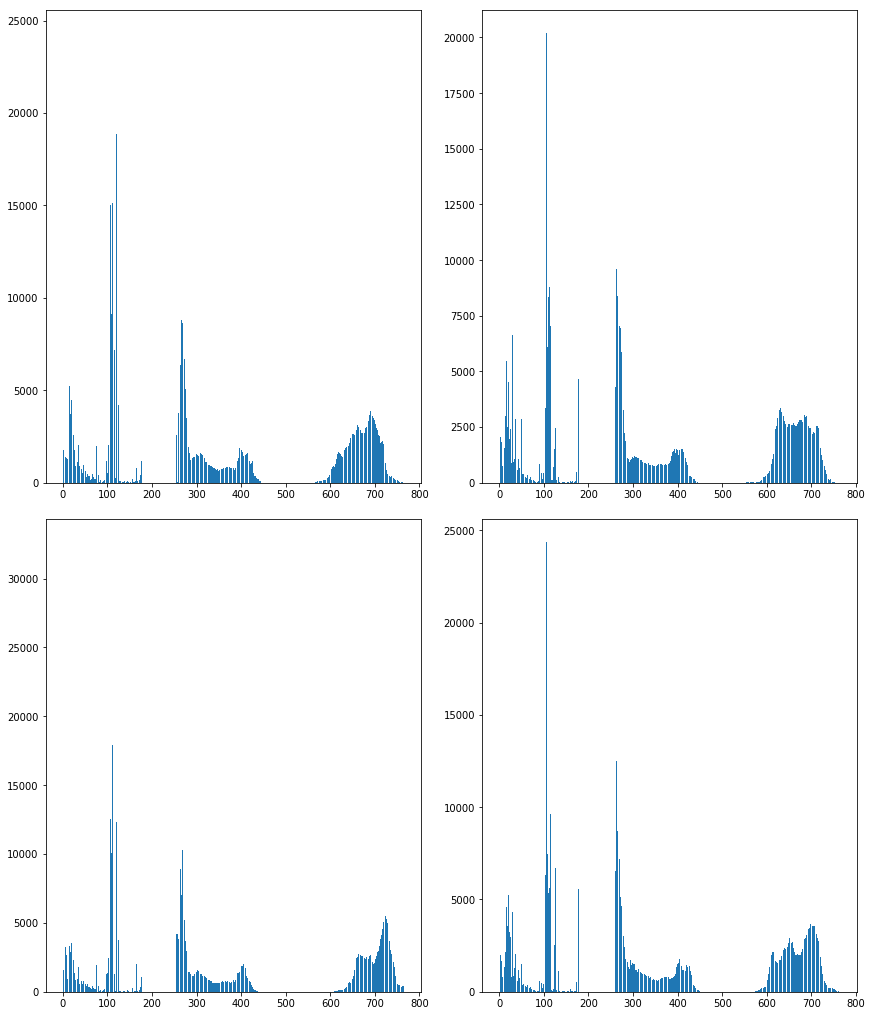

In [19]:
plot_patch(queries[i], hist_coll_hsv, hist=True)

And indeed, now we were able to identify all 4 photos of an object as the most similar one. We can also observe that histograms for those 4 images now all pretty similar. Other images in top 10, as expected, also have a lot of similar blueish and greyish colors but completely unrelated objects. That drawback is expected limitation of an algorithm, since it only compares colors and not their geospatial properties

## Checking other examples

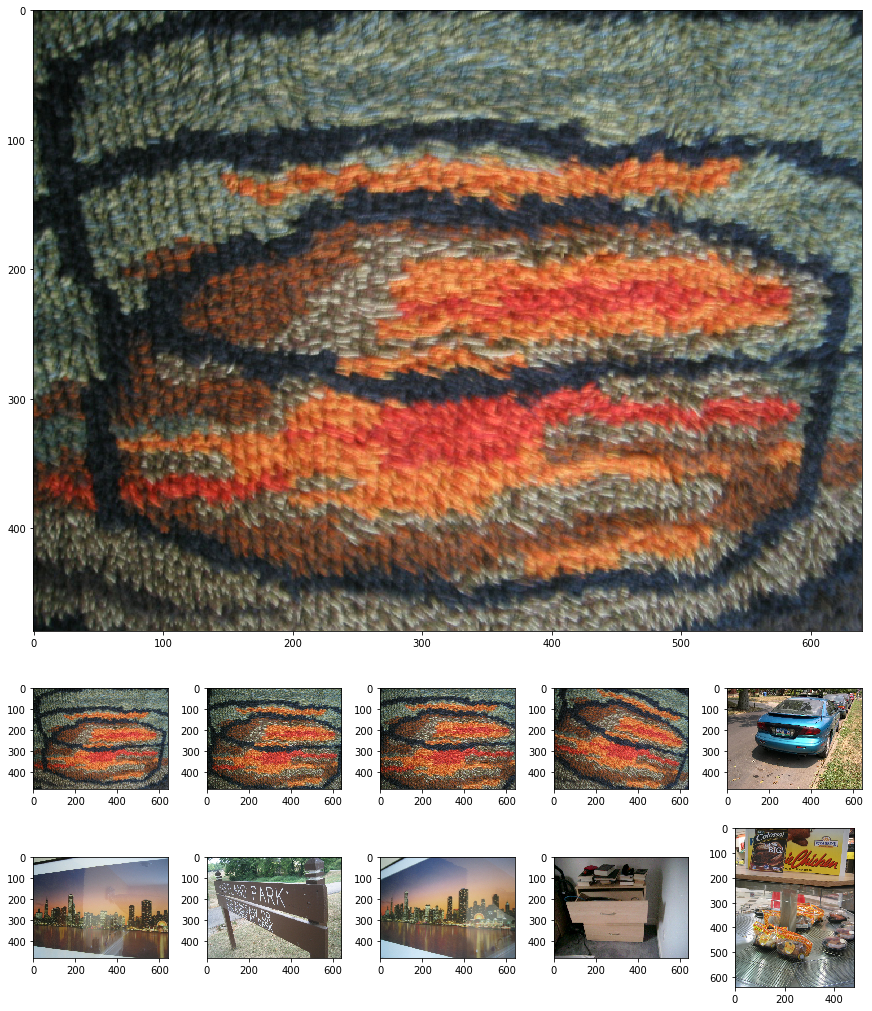

In [20]:
i += 1
query = frame_coll[queries[i]]
matches = np.take(frame_coll, match_coll[i], axis=0)
plot_matches(query, matches)

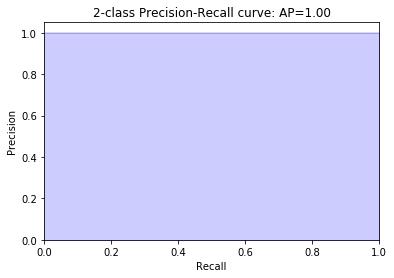

In [21]:
pr_curve(queries[i], dist_coll[i])

With carpet we also have a perfect match of all 4 photos. But what concerns the following 3 request, there we identified only 2-3 out of 4 expected photos. Let's check results and think what might be the problem

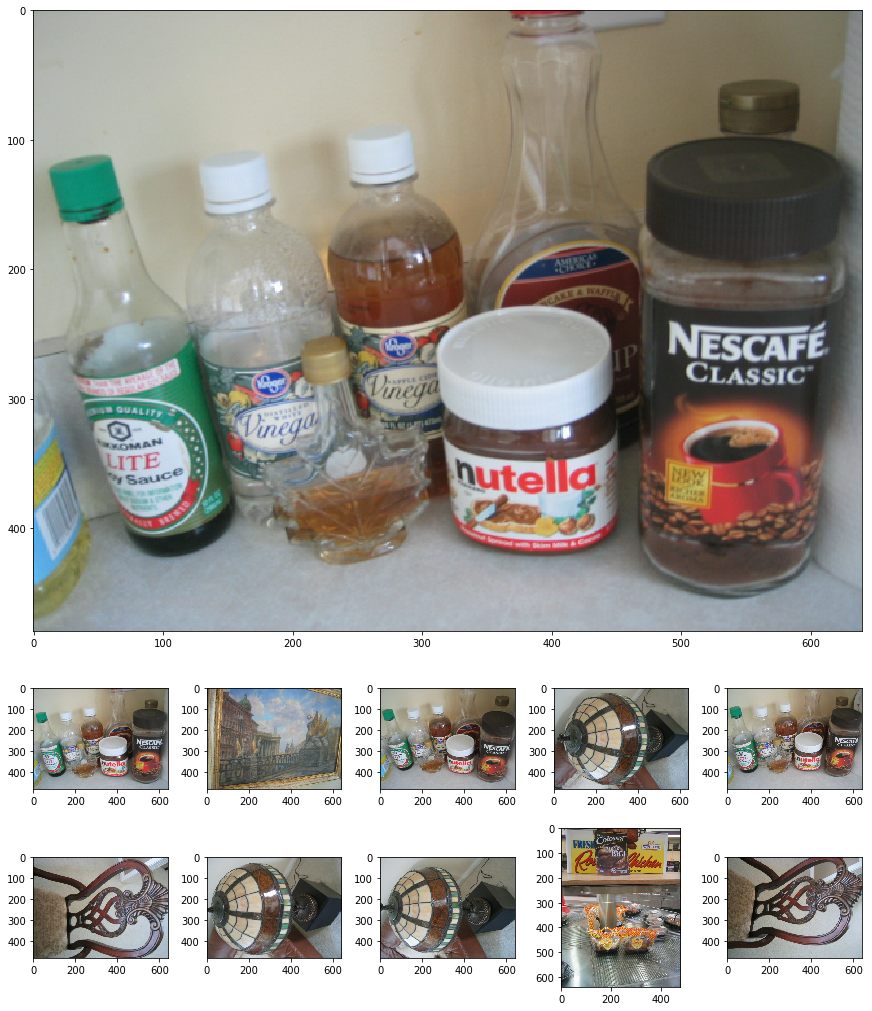

In [22]:
i += 1
query = frame_coll[queries[i]]
matches = np.take(frame_coll, match_coll[i], axis=0)
plot_matches(query, matches)

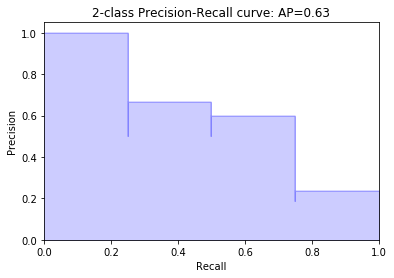

In [23]:
pr_curve(queries[i], dist_coll[i])

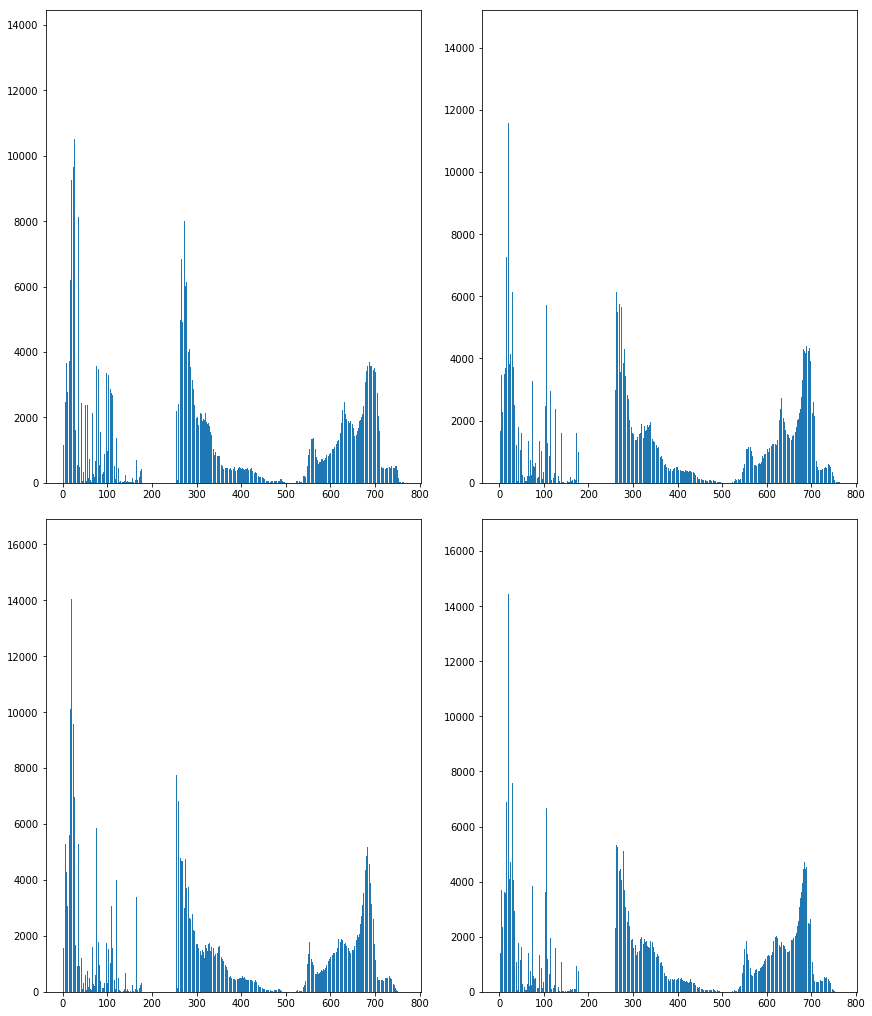

In [24]:
plot_patch(queries[i], hist_coll_hsv, hist=True)

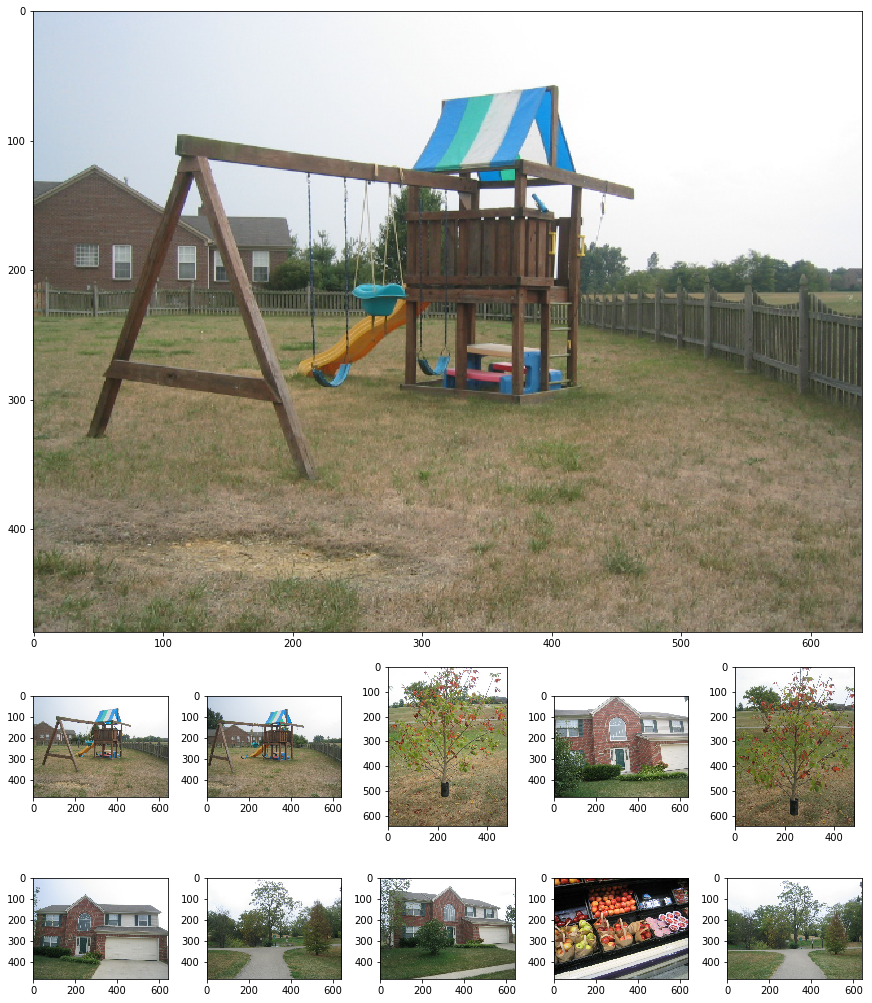

In [25]:
i += 1
query = frame_coll[queries[i]]
matches = np.take(frame_coll, match_coll[i], axis=0)
plot_matches(query, matches)

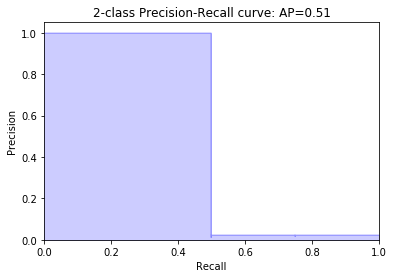

In [26]:
pr_curve(queries[i], dist_coll[i])

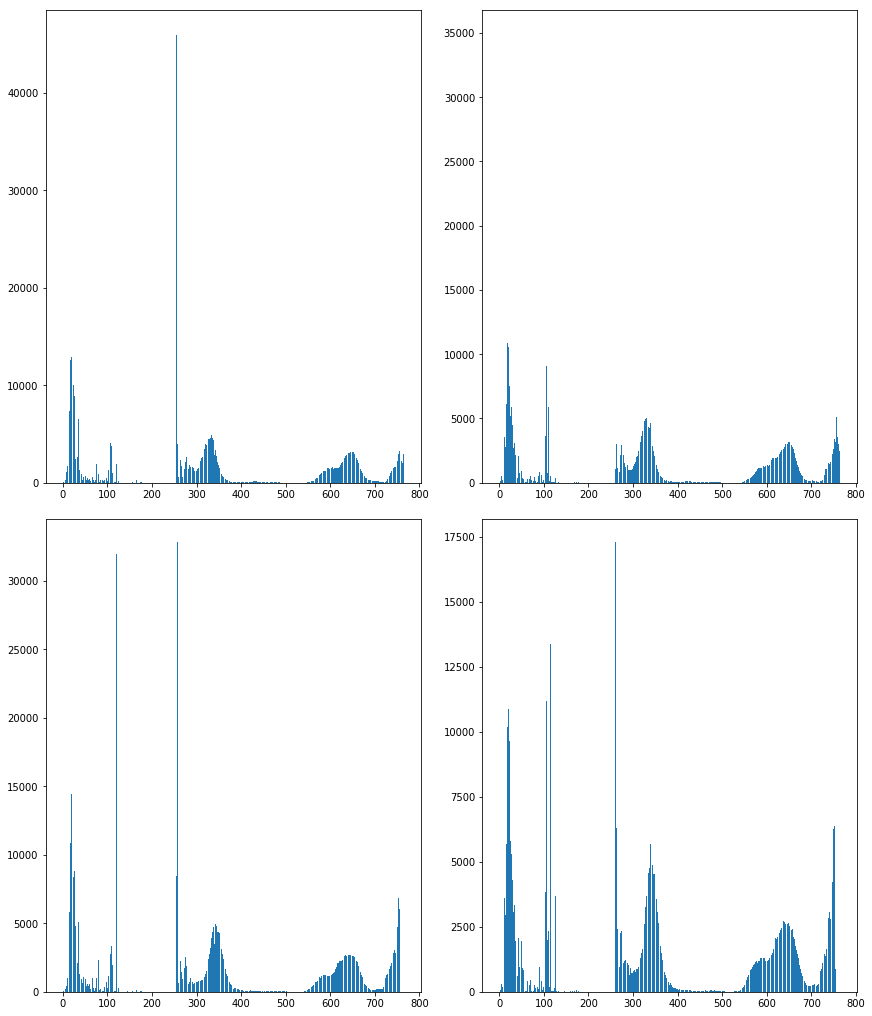

In [27]:
plot_patch(queries[i], hist_coll_hsv, hist=True)

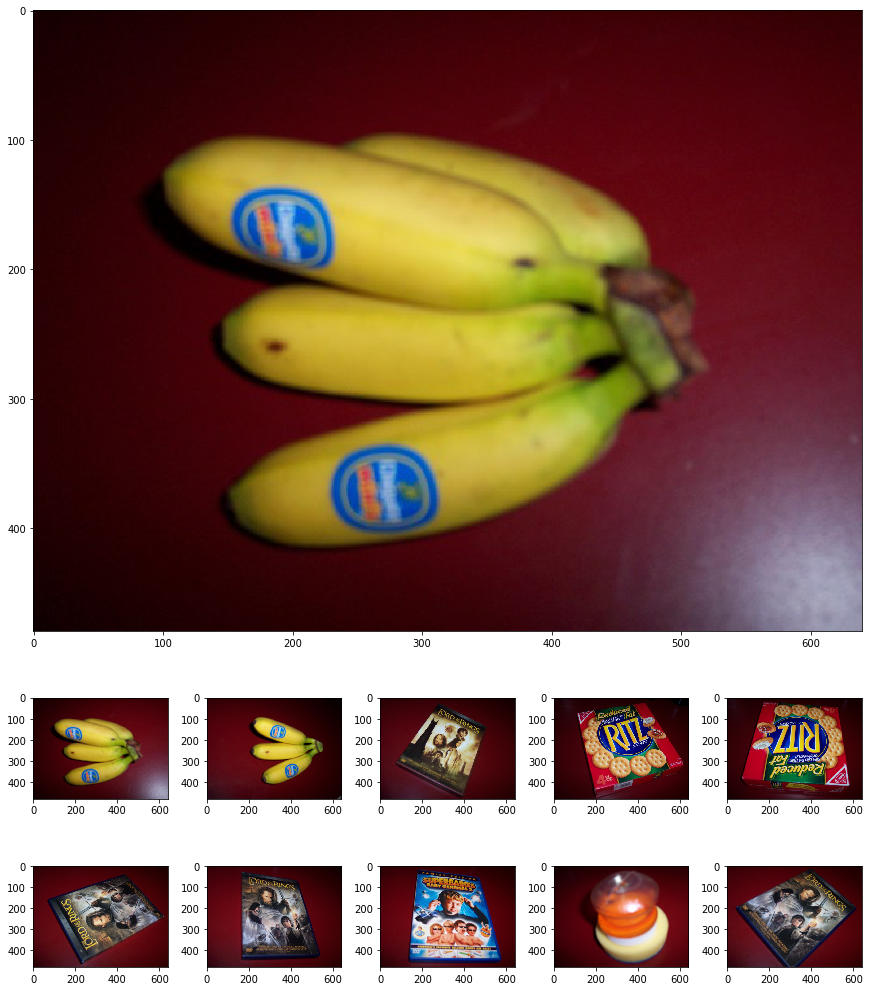

In [28]:
i += 1
query = frame_coll[queries[i]]
matches = np.take(frame_coll, match_coll[i], axis=0)
plot_matches(query, matches)

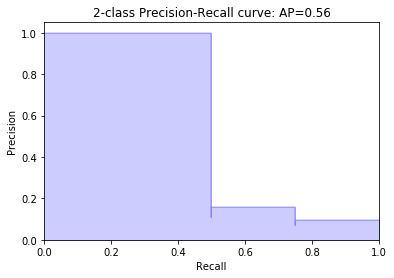

In [29]:
pr_curve(queries[i], dist_coll[i])

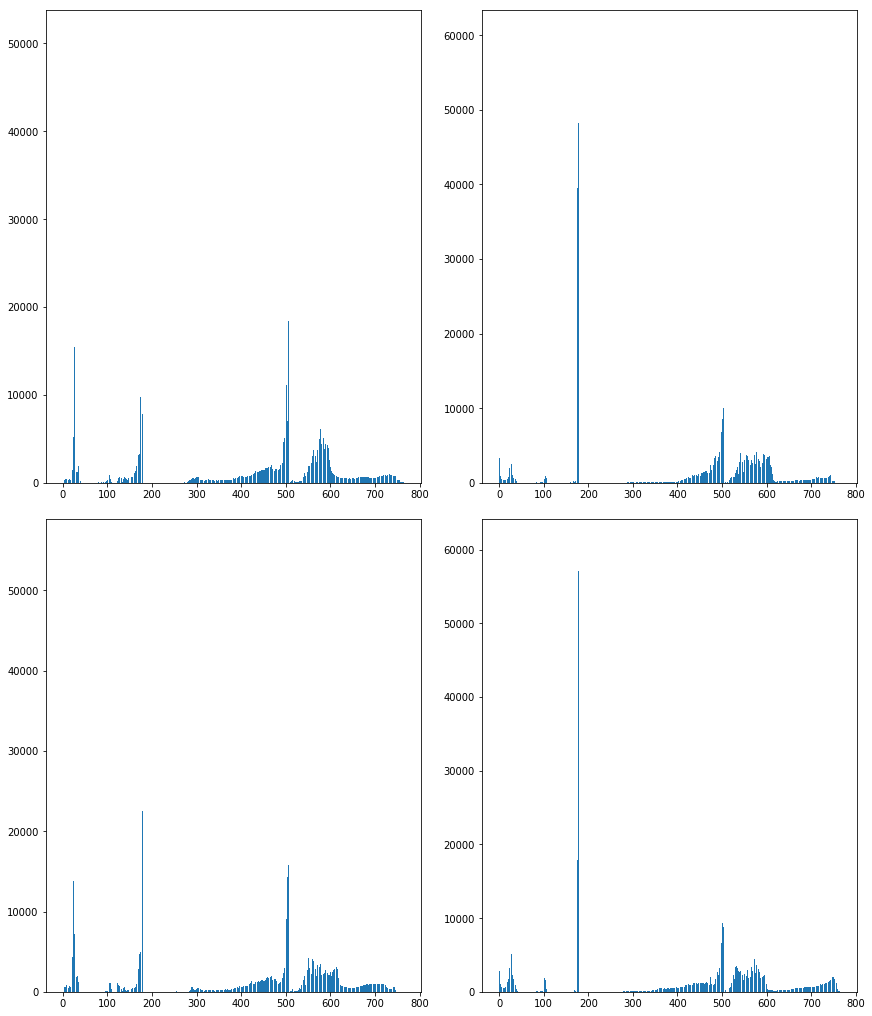

In [30]:
plot_patch(queries[i], hist_coll_hsv, hist=True)

Generally, for all cases, we have all images with similar colors, even though it's not similar objects. Mostly, we have a similar background for all discovered images, be it a red table or green grass. When we take a look into histograms of target images, they also have 2 interesting insights:
* they have the same patterns (even though we didn't find them with an algorithm)
* all of them have enormously huge bins for a few color intensities, which is the color of the background.

Indeed, if we compare the difference between first 2 queries with perfect results and the last 3, the main difference is that objects on first 2 queries cover most of an image with a little background. While the last 3 have a relatively large portion of the background, our algorithm searches for similar background rather than for similar object.

That is because L2 norm gives a huge penalty for outliers and thus the algorithm is trying to have as small error for those the highest bars (corresponding to background) as possible.

We might try to fix it with the following approaches:
* try to identify high anomaly bars(background) and remove them from feature-vector
* change penalty function to L1 or another, which doesn't give that big penalty on few big outliers